# Data Analysis

In this notebook, I have tried to explore the most common questions that can provide value to the model developement process.

In [1]:
from EDA_busiess_case_analysis_ import EdaBusinessCase as eda

In [2]:
import gc
from time import time
import plotly.express as px

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
path_base = ''

In [5]:
reference = eda(path_base)

## Daily aggregates

In [6]:
daily_aggregate = reference.daily_aggregate()

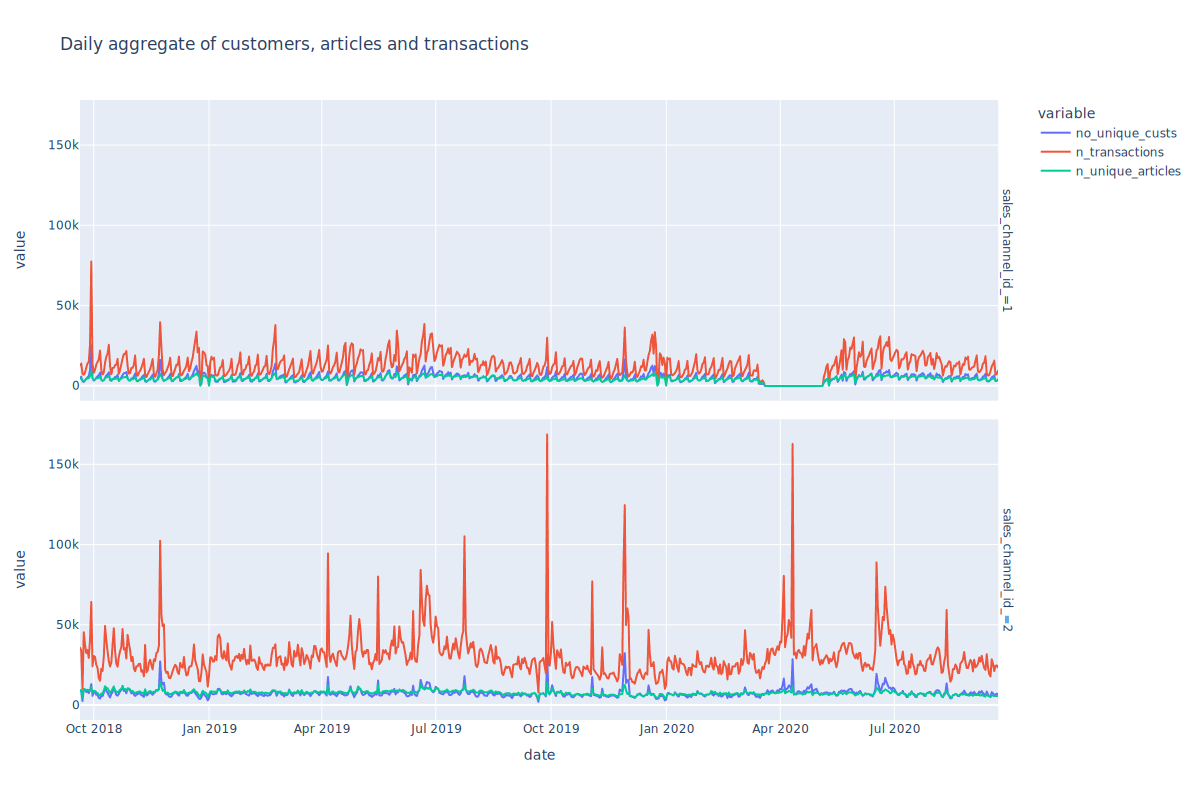

In [7]:
fig = px.line(data_frame=daily_aggregate, 
       x='t_dat_', 
       y=['no_unique_custs', 'n_transactions', 'n_unique_articles'],
       facet_row='sales_channel_id_',
        labels={'t_dat_': 'date'},
        title='Daily aggregate of customers, articles and transactions')

fig.show(width = 1200, height = 800)

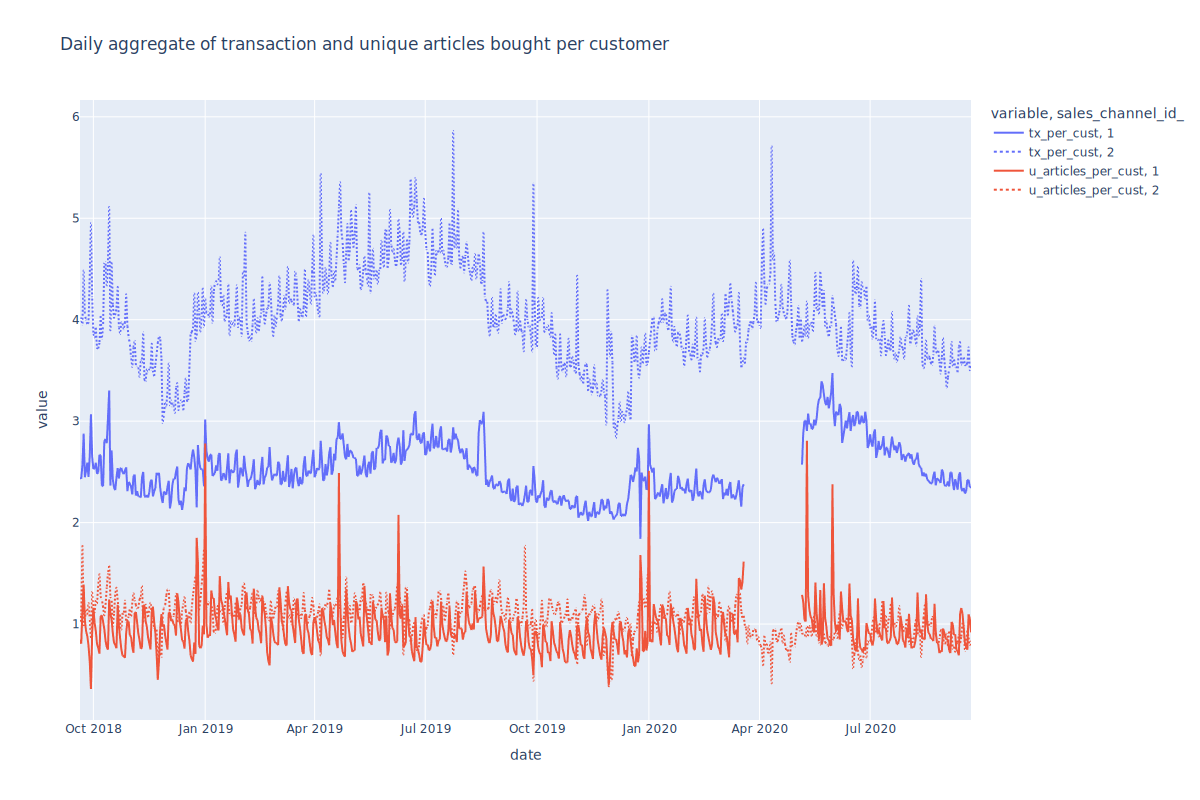

In [8]:
fig = px.line(data_frame=daily_aggregate, 
              x='t_dat_', 
              y=['tx_per_cust', 'u_articles_per_cust'],
              line_dash='sales_channel_id_',
              labels={'t_dat_': 'date'},
              title='Daily aggregate of transaction and unique articles bought per customer')

fig.show(width = 1200, height = 800)

### Observation
- Channel 1 is store, 2 is online.
- No sales from march 20 to may 6 in stores.
- On average more unique articles are bought in stores then online.
- Online has more transactions per customer (how does it affect modelling?)
- During covid restrictions number of transactions per customer were increased (Probably due to closed stores) but number of unique item purchases went down.

In [9]:
## book keeping
del(daily_aggregate)
gc.collect()

1546

In [10]:
article_subset = reference.article_subset_info()
article_subset.head(-1)

,unique,top,freq
prod_name,45875,Dragonfly dress,98
graphical_appearance_name,30,Solid,49747
garment_group_name,21,Jersey Fancy,21445
perceived_colour_value_name,8,Dark,42706


Too many options here, therefore, gonna stick to `index_group_name` (this is better), `index_name`, `product_group_name`, `perceived_colour_value_name` only.

### Distribution of article sale over days

In [11]:
df_season = reference.season_analysis()

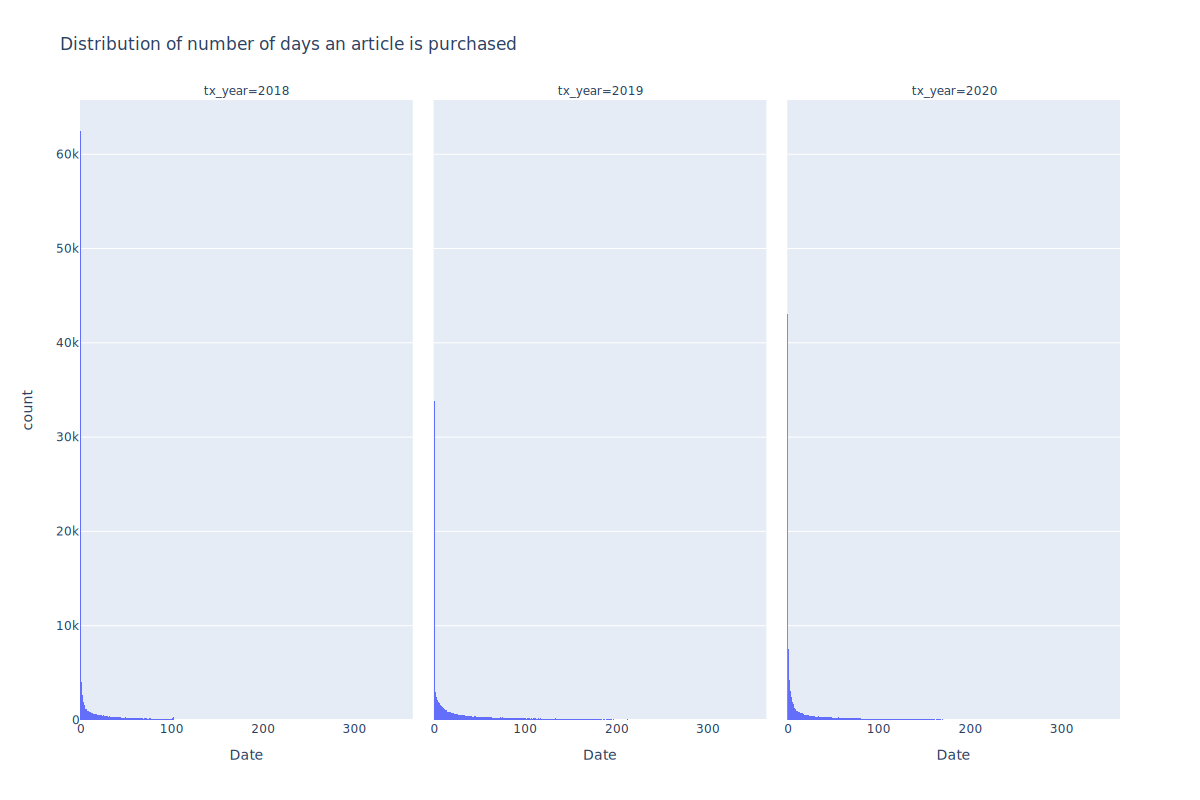

In [12]:
fig = px.histogram(df_season, x='t_dat', facet_col='tx_year',
            title='Distribution of number of days an article is purchased', labels={'t_dat': 'Date'})
fig.show(width = 1200, height = 800)

In [13]:
df_season.groupby(['tx_year'])['t_dat'].agg(['mean', 'median'])

,mean,median
tx_year,,
2018,10.820358,0.0
2019,36.256497,8.0
2020,24.121218,2.0


In [14]:
del(df_season)

Observation
- The idea behind this graph is to understand if there are articles that are availbale for a shorter period of time as seasonality plays an important part in garment retails.
- Most articles are purchased for shorter period of time. (maybe we can filter predictions to recommend recently purchased articles such as in last 36 days)

## Unique available products per year (based on product name)

In [15]:
df_prod_per_year = reference.products_per_year()

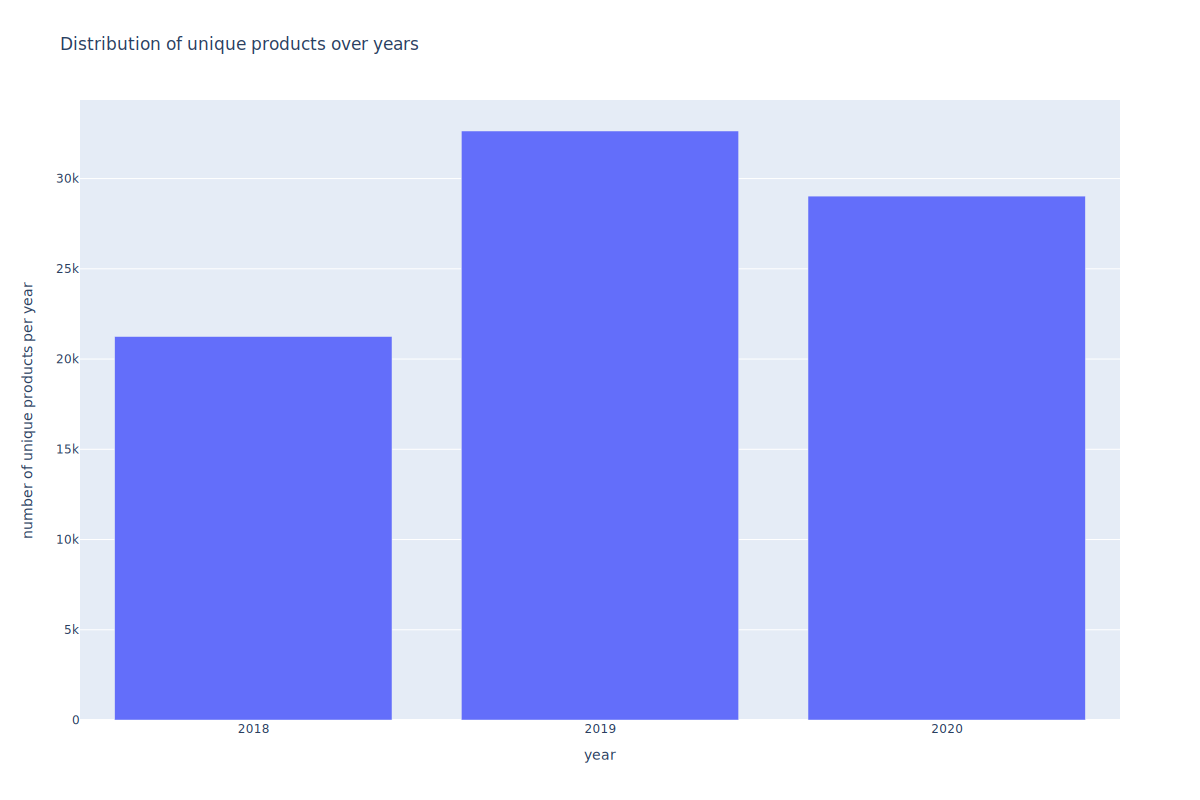

In [16]:
fig = px.bar(df_prod_per_year.astype({'tx_year': str}), 
       x='tx_year', 
       y='n_unique_prods', 
       title='Distribution of unique products over years',
      labels={'n_unique_prods': 'number of unique products per year', 'tx_year': 'year'})

fig.show(width = 1200, height = 800)

## Available transaction dates per year
- 2018 is second part of the year while 2020 has first 9 months of the year. 

In [17]:
available_dates = reference.return_available_dates()
available_dates.head()

,min,max
tx_year,,
2018,2018-09-20,2018-12-30
2019,2018-12-31,2019-12-29
2020,2019-12-30,2020-09-22


In [18]:
del (df_prod_per_year, available_dates)
gc.collect()

1645

## Distribution of products wrt to purchases over months

- By this analysis, I want to check if there is a seasonality wrt the purchased products. i.e. are certain products purchased throughout the year?
- This graph shows the number of unique months a product is purchased over a year.


After running `product_type_name`, `product_group_name`, `section_name` etc. we know these columns are not granular enough to be separated by sale season or month. They provide more genereric overview of the garment.

In [19]:
df_prod_season2 = reference.prod_season()
df_prod_season2 = df_prod_season2[df_prod_season2.tx_month > 0]

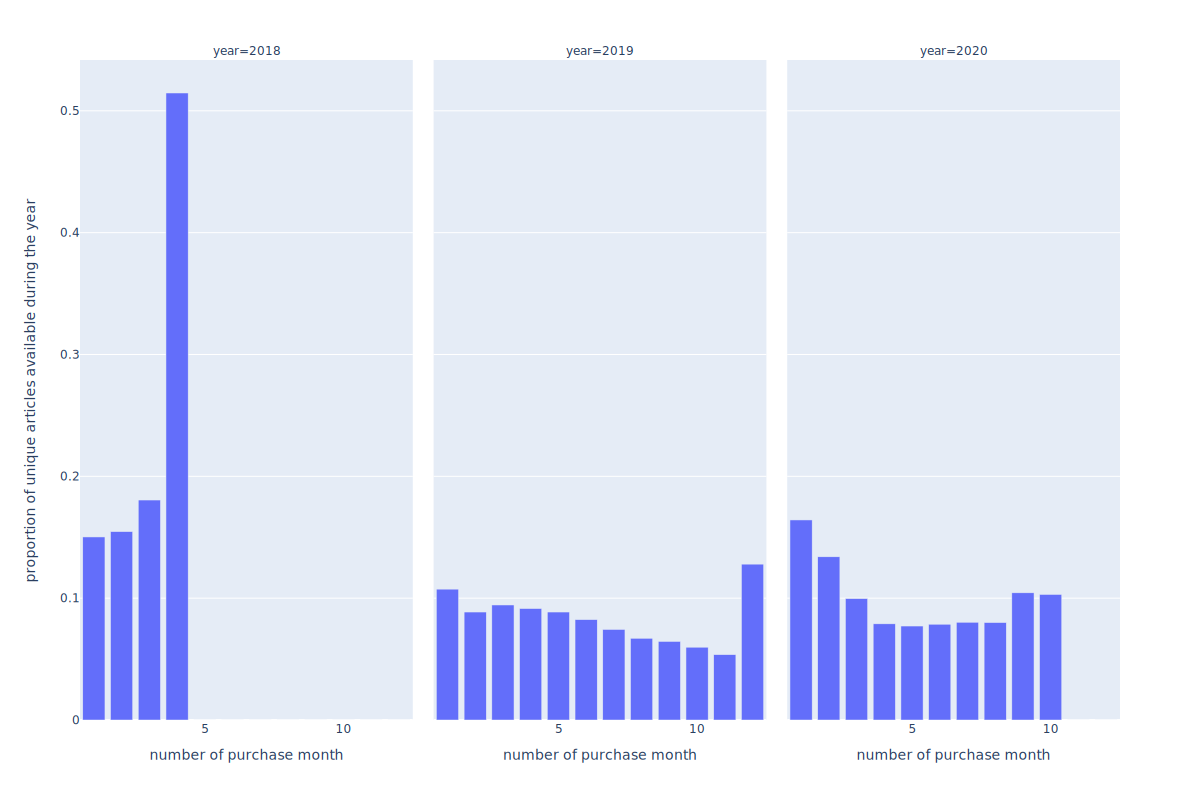

In [20]:
fig = px.bar(df_prod_season2, 
       x='tx_month', 
       y= 'prod_year_prop_sale', 
       facet_col='tx_year', 
       barmode='group',
       labels={'tx_year': 'year', 'tx_month': 'number of purchase month', 'prod_year_prop_sale': 'proportion of unique articles available during the year'})
fig.show(width = 1200, height = 800)

### Observation
- For 2018 we only have 4 months of data therefore, most articles were purchased all 4 months.
- Most garments/items were bought for few month or in a season.
- Introducing season based on the months would be easier to comprehend.
- Month is an important feature to be considered for modelling and ranking.

In [21]:
del(df_prod_season2)

## Does garment color and other dimension have any effect on seasonality
- seasonality defined as month of sale

### Using `graphical_appearance_name`

In [22]:
df_color = reference.colour_analysis1()

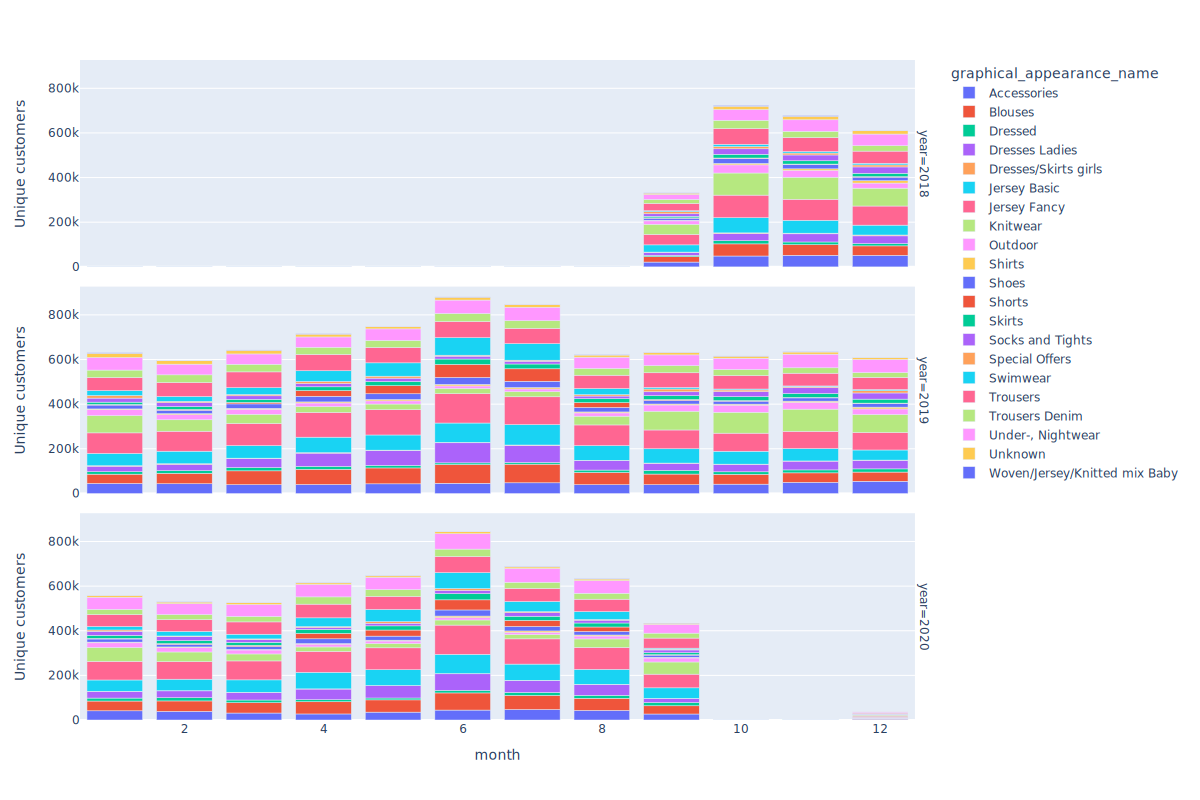

In [23]:
fig = px.bar(df_color, 
           x='tx_month', 
           y='n_unique_customers',
           color='graphical_appearance_name', 
           facet_row='tx_year',
           labels={'tx_month': 'month', 'n_unique_customers': 'Unique customers', 'tx_year': 'year'})
fig.show(width = 1200, height = 800)

#### Observation
- "All over pattern" articles has the most unique customer interested in during 6th and 7th month. (can be described as popularity)
- Too many values nothing much of relevance here.

In [24]:
del df_color
gc.collect()

3140

### Using `perceived_colour_value_name`

In [25]:
df_color = reference.colour_analysis2()

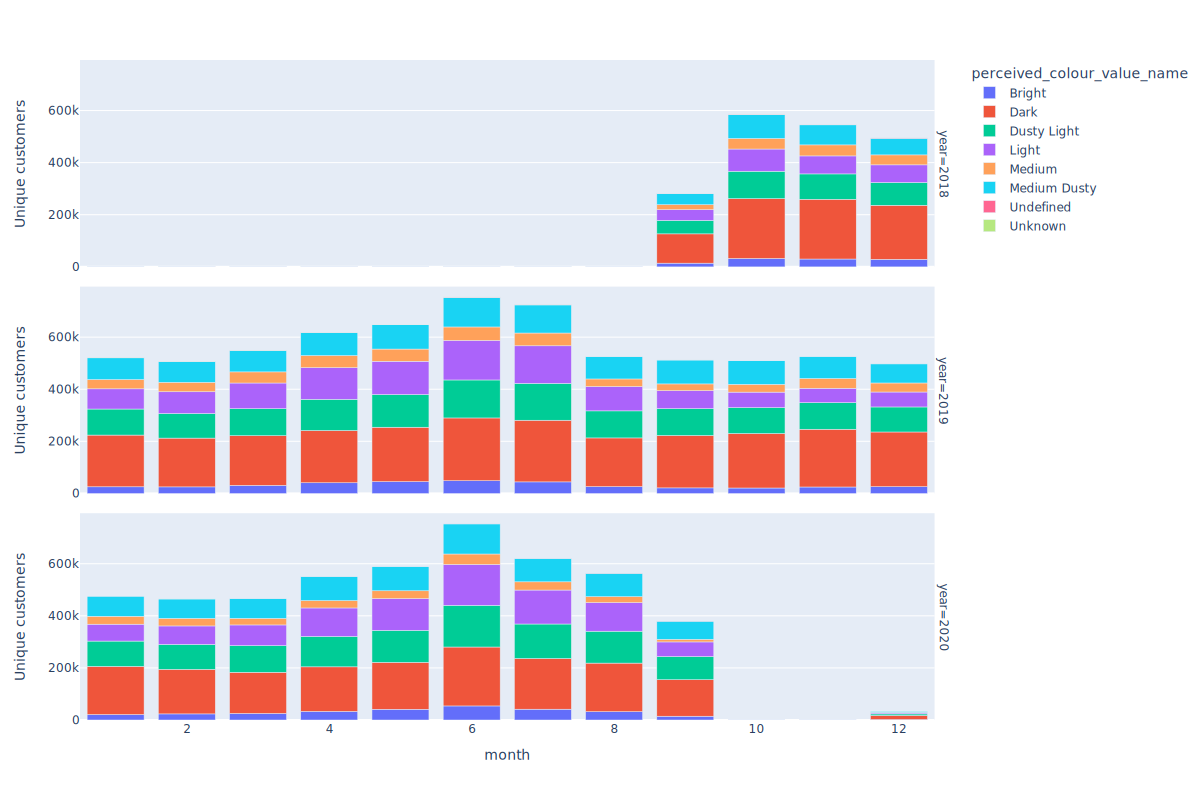

In [26]:
fig = px.bar(df_color, 
           x='tx_month', 
           y='n_unique_customers',
           color='perceived_colour_value_name', 
           facet_row='tx_year',
           labels={'tx_month': 'month', 'n_unique_customers': 'Unique customers', 'tx_year': 'year'})
fig.show(width = 1200, height = 800)

#### Observation
- More customers are interested in dusty light and light items during first half of the year.
- No one wants bright color
- Dark perceived items are more popular.

### Perceived color distribution wrt garment groups

In [27]:
df_color = reference.colour_analysis3()

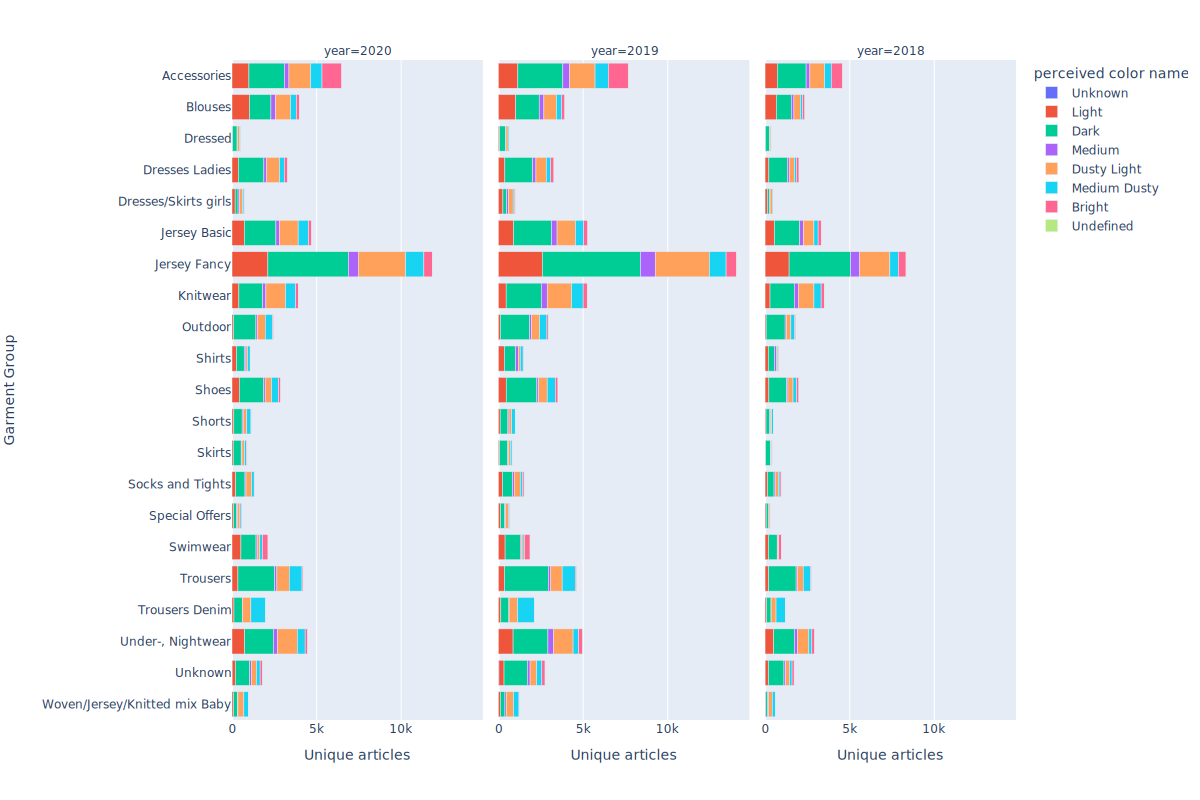

In [28]:
fig = px.bar(df_color.sort_values(by='garment_group_name', ascending=False), 
           y='garment_group_name', 
           x='n_unique_articles',
           color='perceived_colour_value_name', 
           facet_col='tx_year',
           labels={'garment_group_name': 'Garment Group', 'n_unique_articles': 'Unique articles', 'tx_year': 'year', 
                  'perceived_colour_value_name': 'perceived color name'})
fig.show(width = 1200, height = 800)

### Popular segments wrt sale
- price not a good indicator as we have partial data for 2018 and 2020.
- Ladieswear is making the most money for the business. 
(perhaps a model can be tuned towards this segment or we proceed with caution for this bias in the dataset)

In [29]:
df_color = reference.color_analysis4()
df_color.sort_values(by='garment_group_name', ascending=False, inplace=True)

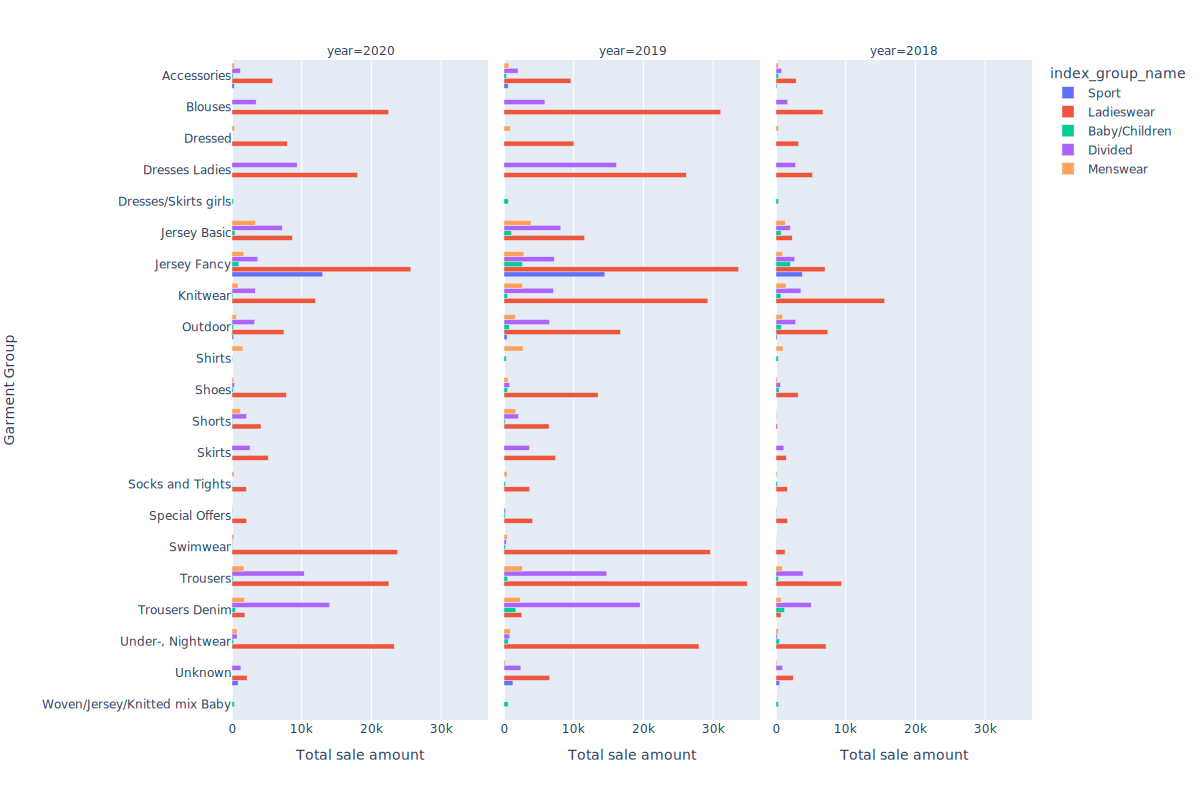

In [30]:
fig = px.bar(df_color, 
       y='garment_group_name', 
       x='total_sale_amount', 
       facet_col='tx_year',
       color='index_group_name',
       barmode='group',
       labels={'total_sale_amount': 'Total sale amount', 'garment_group_name': 'Garment Group', 'tx_year': 'year'})

fig.show(width = 1200, height = 800)

In [31]:
del(df_color)
gc.collect()

5748

## Customer buying patters

### How often a customer is buying in a given period? weekly

In [32]:
purchase_freq_ = reference.purchase_frequency()

execution time  120.31612086296082


In [33]:
## filtering to removes 0s added by grouping
purchase_freq_ = purchase_freq_[(purchase_freq_.n_transactions > 0) & (purchase_freq_.n_customers > 0)]

In [34]:
purchase_freq_.head()

,tx_year,tx_week,sales_channel_id,n_transactions,n_customers
12211,2018,38,1,1,5995
12212,2018,38,1,2,3948
12213,2018,38,1,3,2445
12214,2018,38,1,4,1364
12215,2018,38,1,5,740


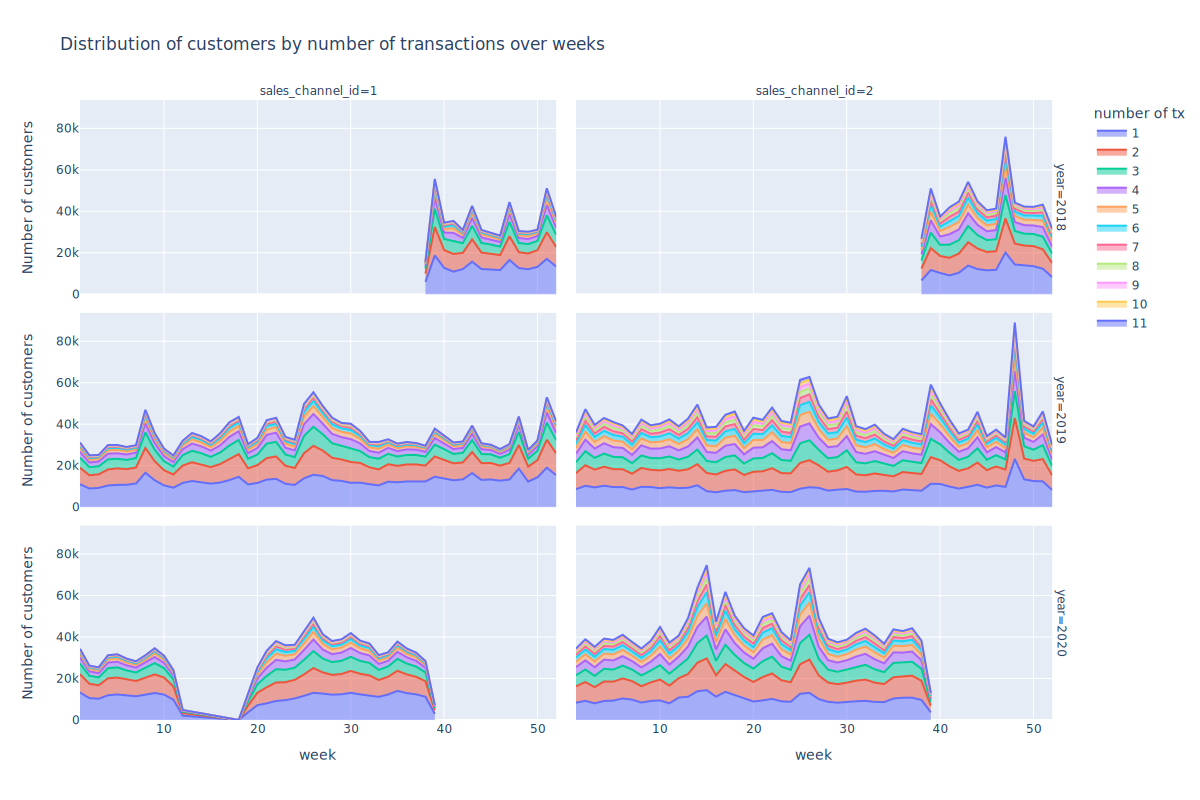

In [35]:
fig = px.area(data_frame=purchase_freq_[purchase_freq_.n_transactions < purchase_freq_.n_transactions.quantile(q=0.25, interpolation='nearest')],
      x='tx_week', 
      y='n_customers', 
      facet_row='tx_year',
      facet_col='sales_channel_id',
      color='n_transactions',
      labels={'n_customers': 'Number of customers', 'tx_year': 'year', 'n_transactions': 'number of tx', 'tx_week': 'week'},
      title='Distribution of customers by number of transactions over weeks')

fig.show(width = 1200, height = 800)

#### Observation
- Only showing results where the number of transactions per week is within first quantile. 
- This reduces the results to display in the plot as we can see from the table most customers are generating fewer transactions per week
- Most customers are making 1-3 transactions per week. (Model evaluation of 12 items per week/bucket seems a bit harsh or maybe the test/validation data is baised towards customers making more purchases? TBD) Maybe a successful business model needs to predict/rank 3 items most likely to be purchased next?

In [36]:
del(purchase_freq_)
gc.collect()

2794

### Distribution of repeating customers (weekly purchase)
- The grapgh shows the distribution of customers over number of purchase weeks per year and sale channel id.
- Long tail dstribution: most customers have made purchases (or were active) for 1-3 weeks. (Model needs to generalise well for customers with fewer transactions )

In [37]:
a = time()
rep_customer = reference.repeating_customer()
## aggregation results in 0 accumulation 
rep_customer = rep_customer[rep_customer.tx_week > 0]

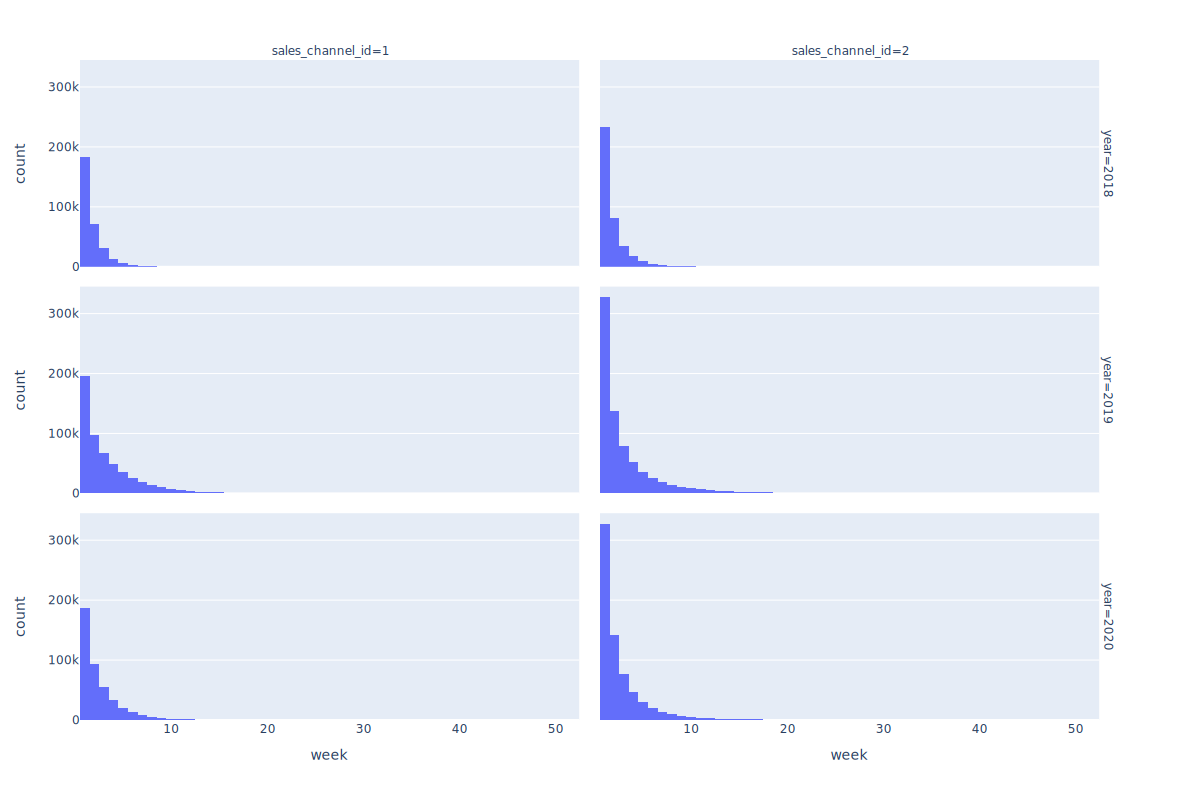

In [38]:
fig = px.histogram(rep_customer, x='tx_week', facet_col='sales_channel_id', facet_row='tx_year', 
      labels={'count': 'Number of customers', 'tx_year': 'year', 'tx_week': 'week'})
fig.show(width = 1200, height = 800)

In [39]:
print(time() - a)
del (rep_customer)

23.656755924224854


### Distribution of customers over transactions  
Number of customers making transactions per year
- Very few cusotmers make large number of transactions per year. (possible outliers)

In [40]:
a= time()
df_purchase_freq = reference.purchase_freq()

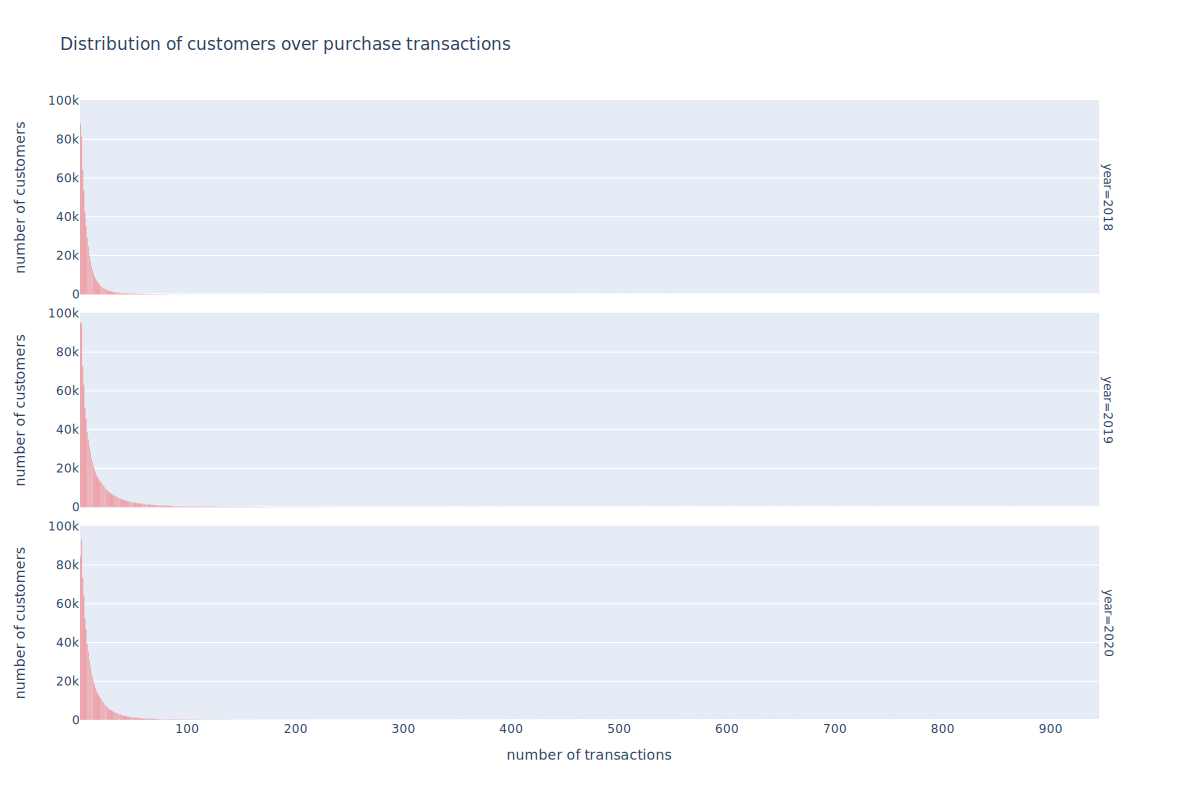

In [41]:
fig = px.bar(data_frame=df_purchase_freq, 
       y='customer_id', 
       x='t_dat',
       labels={'t_dat': 'number of transactions', 'customer_id': 'number of customers', 'tx_year': 'year'},
             title='Distribution of customers over purchase transactions',
       facet_row='tx_year')

fig.update_traces(marker_color='red')
fig.show(width = 1200, height = 800)

In [42]:
print(time() - a)

11.344482183456421


In [43]:
del(df_purchase_freq)
gc.collect()

3681

### Average gap between purchases

In [44]:
df_results = reference.purchase_gap()

execution time in sec,  593.8565449714661


In [45]:
df_results1 = df_results.groupby(['average_gap_bw_purchase_days', 'tx_year']).count().reset_index()

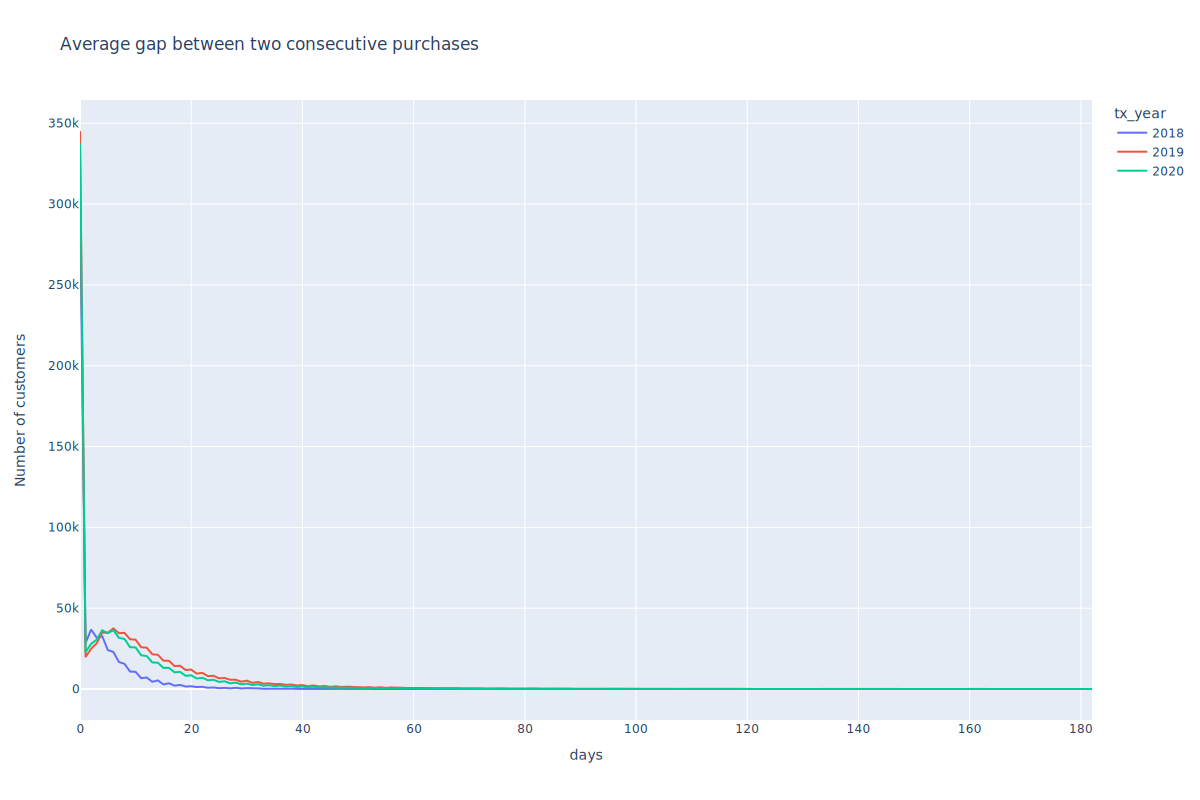

In [46]:
fig = px.line(data_frame=df_results1, 
           x ='average_gap_bw_purchase_days',
           y = 'customer_id',
           color='tx_year',
       title='Average gap between two consecutive purchases',
       labels={'average_gap_bw_purchase_days': 'days', 'customer_id': 'Number of customers'})

fig.show(width = 1200, height = 800)

#### Observation
- The graph shows the difference in days between two consecutive purchases by a customer. Averaged over all customer per year.
- Average gap of 0 days reflect cusotmers with single purchase day (also shown in the previous graph for purchase frequency)
- Therefore, the model need to generalise better on customers with fewer transactions. (hence, it will make sense to evaluate these segments separately)

In [47]:
del(df_results)
gc.collect()

1158

### What products and garment groups are bought together?
Following observations are based on random sample of 1% transactions

In [48]:
test_df = reference.bought_together()
test_df.sort_values(by='n_unique_custs', inplace=True)

13622
execution time in sec,  93.27677202224731


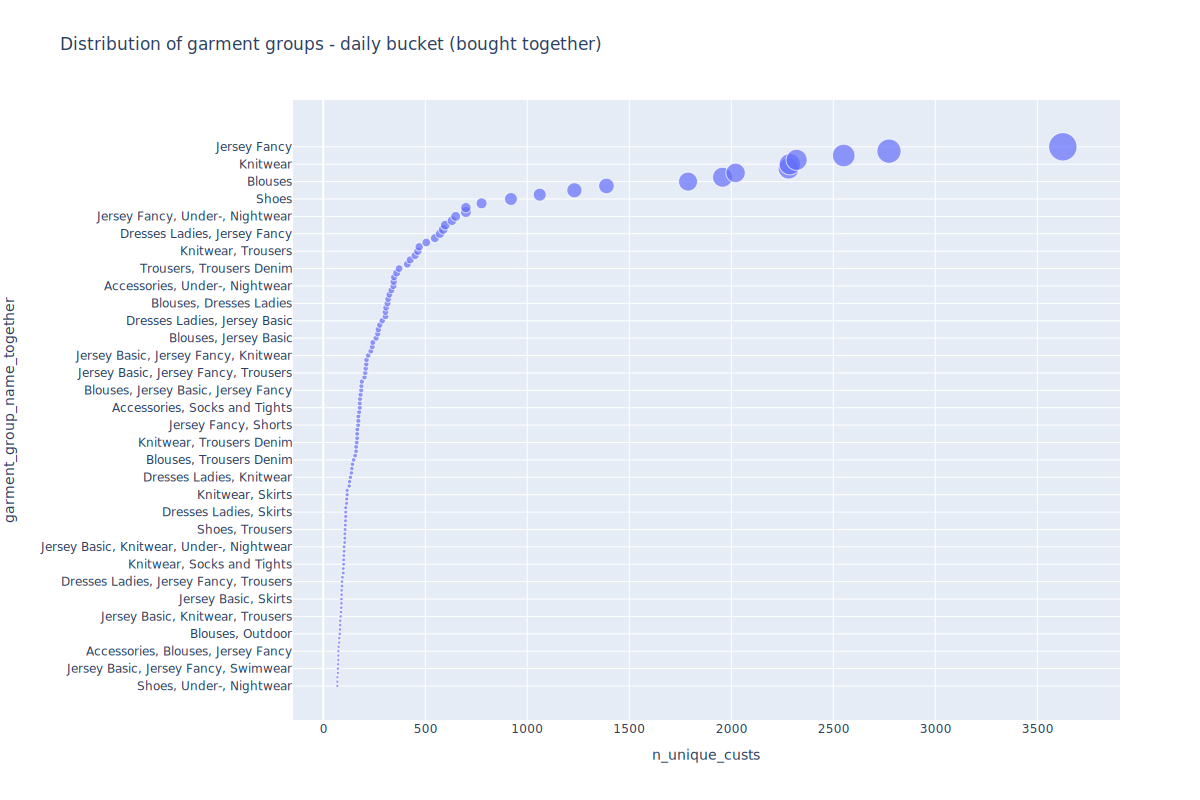

In [49]:
fig = px.scatter(data_frame=test_df, 
           y='garment_group_name_together', 
           x='n_unique_custs', 
           size='total_purchase_days',
          title='Distribution of garment groups - daily bucket (bought together)')

fig.show(width = 1200, height = 800)

Observation
- Garment groups with top 2% unique customers are shown in the graph.
- The size refers to the number of transaction days for each garment group.
- X: number of unique customers making the purchase. Y: garment group bought together.
- Most customers and purchases include single garment group. (what this means for modelling? we can use the items bought together to rank the predictions. Since most customers buys from one garment group this might not provide significant gain in performance TBD)

In [50]:
del (test_df)

### Customer rebuying frequency 
- After the first purchase what's the next two purchases (displayed by the garment group)

In [6]:
new_df_purchase = reference.rebuying_frequency()

13622
next purchase list computation  4.016500949859619
next purchase df generation  25.767249822616577
df concat time  0.7040741443634033


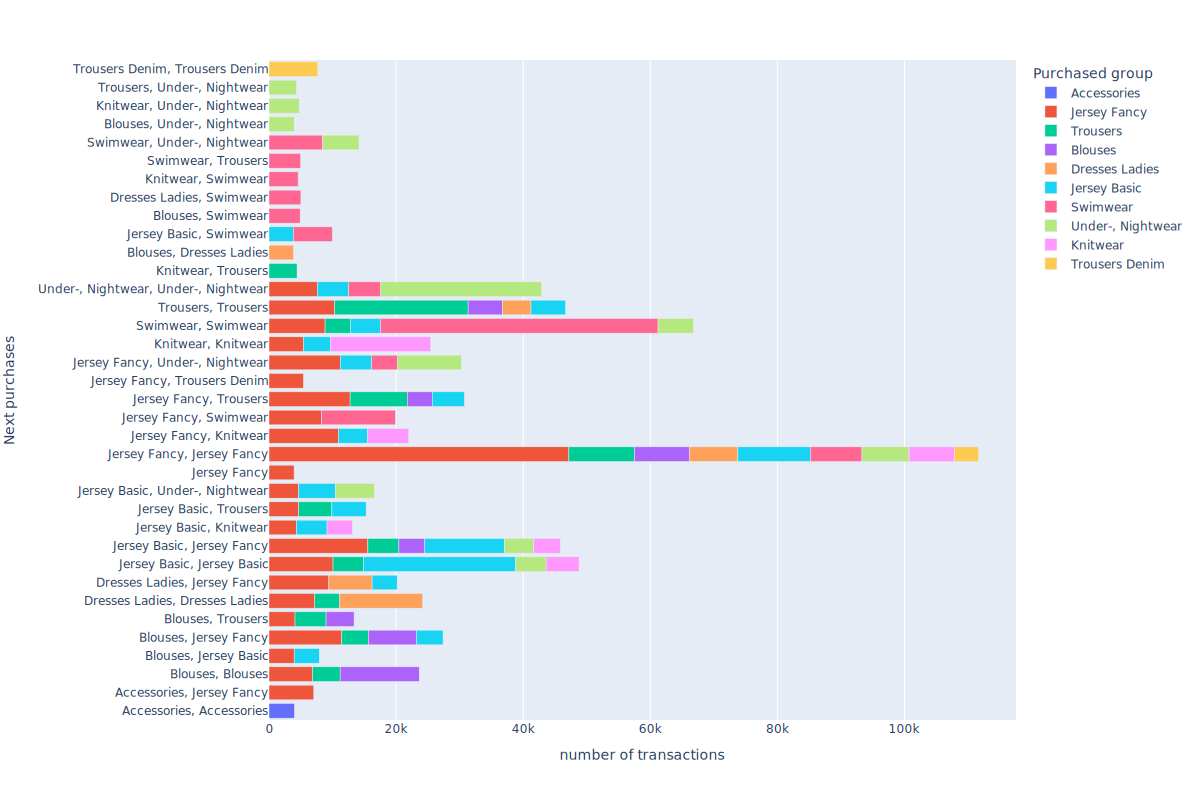

In [7]:
fig = px.bar(data_frame=new_df_purchase.sort_values(by='next_garment_group_name'),
           color='garment_group_name',
           y='next_garment_group_name',
       labels={'t_dat': 'number of transactions', 'garment_group_name': 'Purchased group', 'next_garment_group_name': 'Next purchases'},
           x='t_dat')

fig.show(width = 1200, height = 800)

In [8]:
del (new_df_purchase)
gc.collect()

424